# pomegranate / sklearn GMM comparison

authors: <br>
Nicholas Farn (nicholasfarn@gmail.com) <br>
Jacob Schreiber (jmschreiber91@gmail.com)

<a href="https://github.com/scikit-learn/scikit-learn">sklearn</a> is a very popular machine learning package for Python which implements a wide variety of classical machine learning algorithms. In this notebook we benchmark the GMM implementations in pomegranate and compare it to the implementation in sklearn. In sklearn, GMM refers exclusively to Gaussian mixture models, while in pomegranate it refers to General mixture models, as it is flexible enough to allow any combination of distributions or models to be used as components.

However, a simpler version of the GMM is kmeans clustering. Both pomegranate and sklearn implement these, so lets take a look at those first.

In [1]:
%pylab inline
import seaborn, time
seaborn.set_style('whitegrid')

from sklearn.mixture import GMM
from sklearn.cluster import KMeans
from pomegranate import *

Populating the interactive namespace from numpy and matplotlib


Lets create some functions to evaluate models efficiently. We can start with fitting and predicting against an increasing data size. The data we compare against are Gaussian blobs which are 3 standard deviations away from each other to allow for some, but not a lot of, overlap.

In [2]:
def create_dataset(n_samples, n_dim, n_classes):
    """Create a random dataset with n_samples in each class."""
    
    X = numpy.concatenate([numpy.random.randn(n_samples, n_dim) + i*3 for i in range(n_classes)])
    y = numpy.concatenate([numpy.zeros(n_samples) + i for i in range(n_classes)])
    return X, y

def plot( fit, predict, skl_error, pom_error, sizes, xlabel ):
    """Plot the results."""
    
    idx = numpy.arange(fit.shape[1])
    
    plt.figure( figsize=(14, 4))
    plt.plot( fit.mean(axis=0), c='c', label="Fitting")
    plt.plot( predict.mean(axis=0), c='m', label="Prediction")
    plt.plot( [0, fit.shape[1]], [1, 1], c='k', label="Baseline" )
    
    plt.fill_between( idx, fit.min(axis=0), fit.max(axis=0), color='c', alpha=0.3 )
    plt.fill_between( idx, predict.min(axis=0), predict.max(axis=0), color='m', alpha=0.3 )
    
    plt.xticks(idx, sizes, rotation=65, fontsize=14)
    plt.xlabel('{}'.format(xlabel), fontsize=14)
    plt.ylabel('pomegranate is x times faster', fontsize=14)
    plt.legend(fontsize=12, loc=4)
    plt.show()
    
    
    plt.figure( figsize=(14, 4))
    plt.plot( 1 - skl_error.mean(axis=0), alpha=0.5, c='c', label="sklearn accuracy" )
    plt.plot( 1 - pom_error.mean(axis=0), alpha=0.5, c='m', label="pomegranate accuracy" )
    
    plt.fill_between( idx, 1-skl_error.min(axis=0), 1-skl_error.max(axis=0), color='c', alpha=0.3 )
    plt.fill_between( idx, 1-pom_error.min(axis=0), 1-pom_error.max(axis=0), color='m', alpha=0.3 )
    
    plt.xticks( idx, sizes, rotation=65, fontsize=14)
    plt.xlabel( '{}'.format(xlabel), fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=14) 
    plt.show()
    
def evaluate_kmeans():
    sizes = numpy.around( numpy.exp( numpy.arange(8, 16) ) ).astype('int')
    n, m = sizes.shape[0], 20
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))

    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset( size, 1, 2 )

            pom = Kmeans(2)
            skl = KMeans(2, max_iter=1, n_init=1, precompute_distances=True, init=X[:2].copy())

            # bench fit times
            tic = time.time()
            skl.fit( X )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, max_iterations=1 )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic

            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    
    plot(fit, predict, skl_error, pom_error, sizes, "samples per component")

Below we see the fit and predict speeds for the two algorithms on increasing dataset sizes. pomegranate is always faster than sklearn for both prediction and fitting steps. These numbers fluctuate a bit every run and so running it multiple times (20 in this case) and reporting mean and standard deviations is ideal. Since these are unsupervised algorithms, accuracy is kind of a weird metric, but it refers to assigning cluster labels correctly corresponding to the underlying distribution which generated the data.

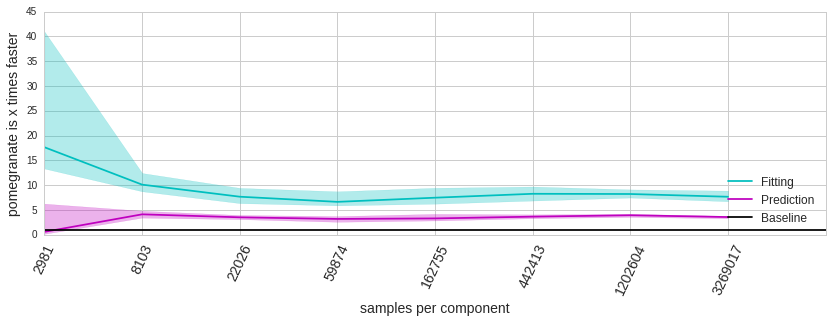

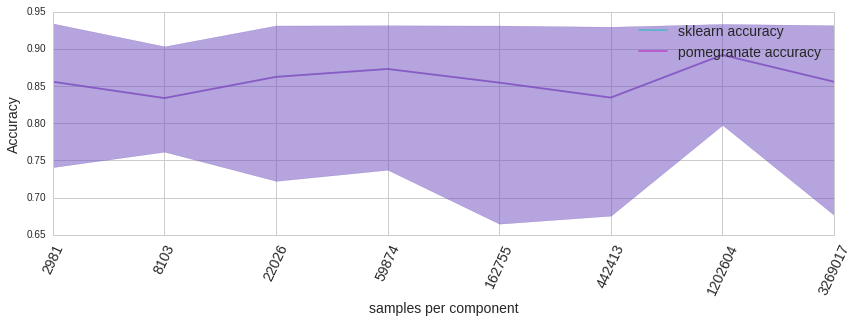

In [3]:
evaluate_kmeans()

The lines show the mean of the plotted value, and the bounds show the minimum and maximum value. We can see that kmeans looks liks it's between 5-10x faster per fitting iteration than sklearn is, and around 3-4x faster when it comes to prediction! To confirm that the two are getting the same results, we plot the unsupervised 'accuracy' for the two, and see that they are identical.  

Lets now look at Gaussian datasets with two components when running Gaussian Mixture Models. We'll look at how many times faster pomegranate is, which means that values > 1 show pomegranate is faster and < 1 show pomegranate is slower. Lets also look at the accuracy of both algorithms. Accuracy should be roughly the same, but different, since both have different random initialization points. The measured the time is the time it takes to do a single iteration of EM.

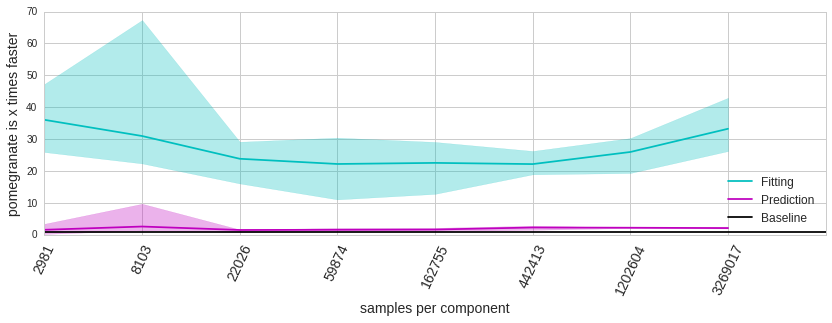

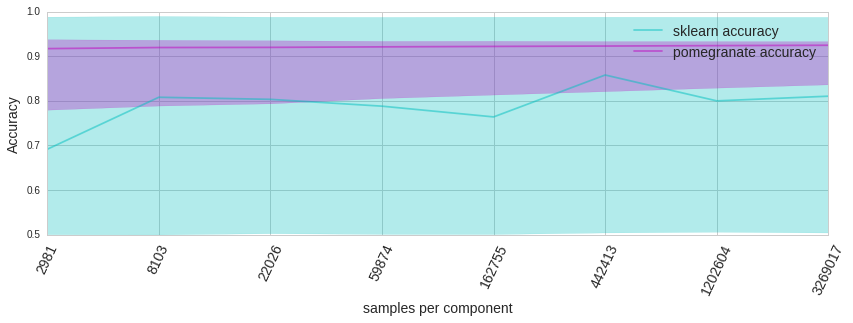

In [4]:
def evaluate_models( skl, pom ):
    sizes = numpy.around( numpy.exp( numpy.arange(8, 16) ) ).astype('int')
    n, m = sizes.shape[0], 20
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))

    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset( size, 1, 2 )

            # bench fit times
            tic = time.time()
            skl.fit( X )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, max_iterations=1 )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic

            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    plot(fit, predict, skl_error, pom_error, sizes, "samples per component")

pom = GeneralMixtureModel( NormalDistribution, n_components=2 )
skl = GMM( n_components=3, n_iter=1 )
evaluate_models( skl, pom )

Lets also see how well it scales as we add more components where there are 10,000 total data points. 

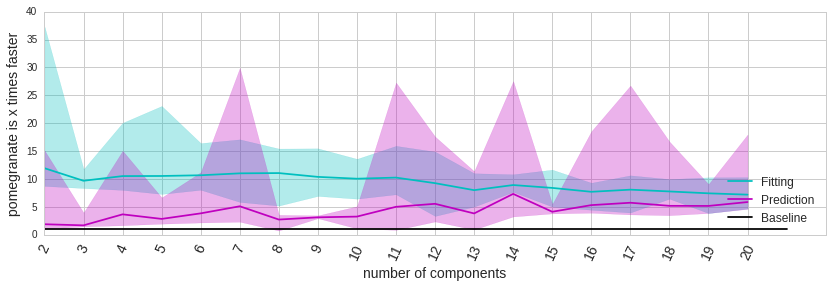

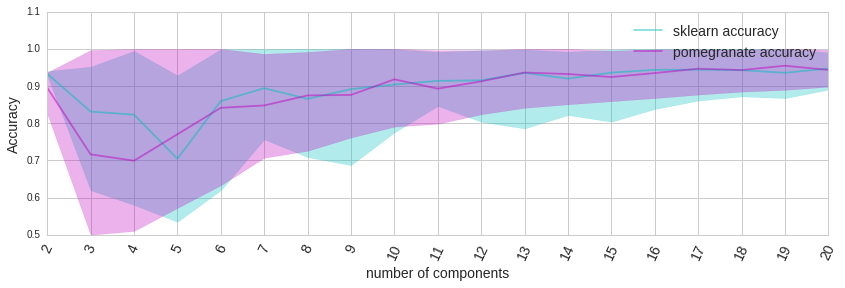

In [5]:
def evaluate_models():
    sizes = numpy.arange(2, 21, dtype='int')
    n, m = sizes.shape[0], 20
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))

    for i in range(m):
        for j, size in enumerate(sizes):
            pom = GeneralMixtureModel( NormalDistribution, n_components=size )
            skl = GMM( n_components=size, n_iter=1 )
        
            X, y = create_dataset(10000 / size, 1, size )

            # bench fit times
            tic = time.time()
            skl.fit( X )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, max_iterations=1 )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic

            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    plot(fit, predict, skl_error, pom_error, sizes, "number of components")

evaluate_models()

Looks like pomegranate can be much faster than sklearn at this task--around 10x faster for the fitting step. The reason that the accuracies vary is because a different random initialization is used for each model.

Now lets take a look at Multivariate Gaussian models. For sklearn the initialization is exactly the same, but for pomegranate the MultivariateGaussianDistribution object must be passed in instead of the NormalDistribution object.

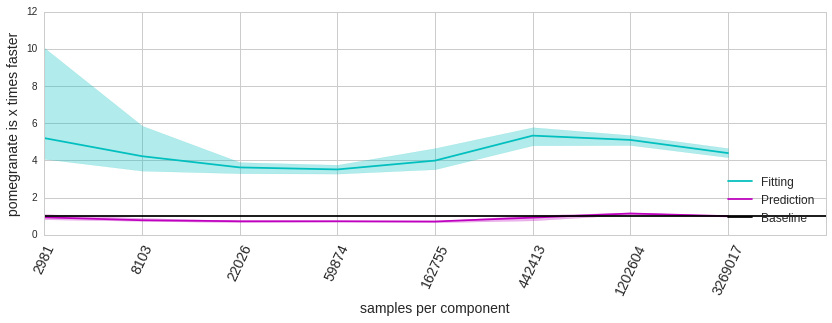

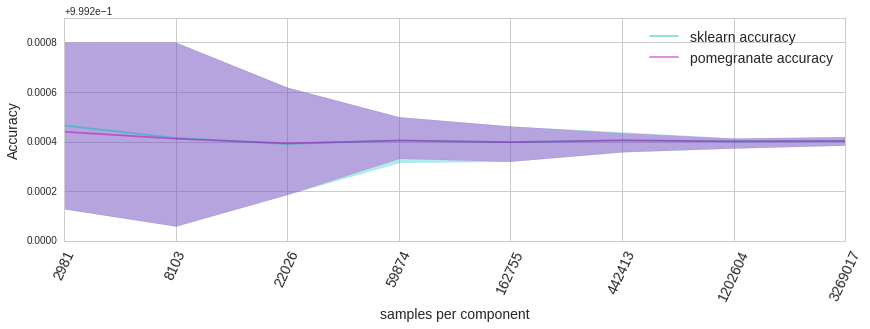

In [6]:
def evaluate_models():
    sizes = numpy.around( numpy.exp( numpy.arange(8, 16) ) ).astype('int')
    n, m = sizes.shape[0], 20
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))

    pom = GeneralMixtureModel(MultivariateGaussianDistribution, n_components=2)
    skl = GMM( n_components=2, n_iter=1 )
    
    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset( size, 5, 2 )
            
            # bench fit times
            tic = time.time()
            skl.fit( X )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, max_iterations=1 )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic
        
            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    plot(fit, predict, skl_error, pom_error, sizes, "samples per component")

evaluate_models()

Looks like pomegranate is faster in the fitting step for multivariate Gaussian mixture models and roughly the same speed for making predictions. The accuracy seems to be pretty much overlapping for these at near perfect.

Lets see how the two models scale when changing the dimensionality of the data between 2 and 20 dimensions.

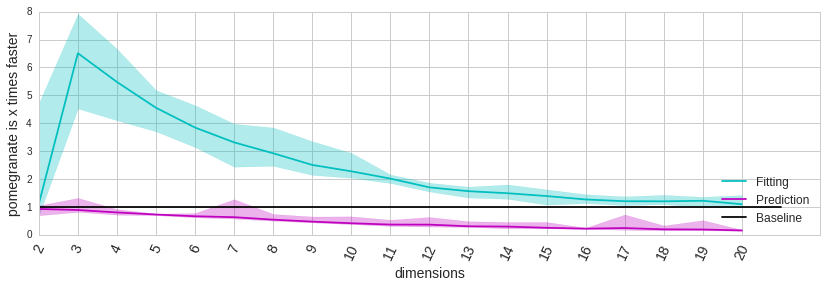

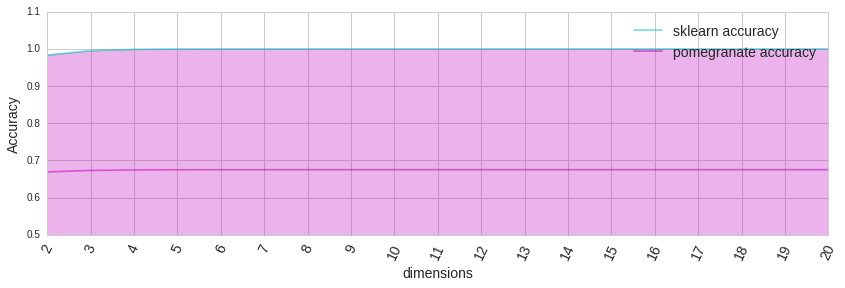

In [7]:
def evaluate_models():
    sizes = numpy.arange(2, 21).astype('int')
    n, m = sizes.shape[0], 20
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))

    pom = GeneralMixtureModel( MultivariateGaussianDistribution, n_components=2 )
    skl = GMM( n_components=2, n_iter=1 )
    
    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset( 50000, size, 2 )
            
            # bench fit times
            tic = time.time()
            skl.fit( X )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, max_iterations=1 )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic
        
            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    plot(fit, predict, skl_error, pom_error, sizes, "dimensions")

evaluate_models()

It seems as though both fitting and prediction using pomegranate scale less well than sklearn to more dimensions, but that it is stil faster. 

This notebook tested a main portion of the overlap between sklearn and pomegranate, but both offer clustering options which aren't displayed here. pomegranate allows any distribution or mixture of distributions, univariate or multivariate, and even some more complex models to be used as a component in the mixture model. The out of core API which pomegranate offers also extends to GMMs, allowing them to be trained using exact EM updates on data which can't fit in memory. In contrast, sklearn offers suppoort for both dirichlet process GMMs (DPGMMs) and variational Bayes GMMs (VBGMMs) as well, which are robust clustering models.

We hope this has been useful to you! If you're interested in using pomegranate, you can get it using `pip install pomegranate` or by checking out the <a href="https://github.com/jmschrei/pomegranate">github repo.</a>